In [137]:
import pandas as pd
import twint
from pytrends.request import TrendReq
pytrends = TrendReq(backoff_factor=0.5)
%run -i 'mod5_functions.py'
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
sns.set(style="darkgrid", font='Verdana', color_codes=True)
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

---

In [33]:
# I am going to leave this here because it is interesting
greenhouse_int = get_int('greenhouse', '2000-01-01 2020-05-16')

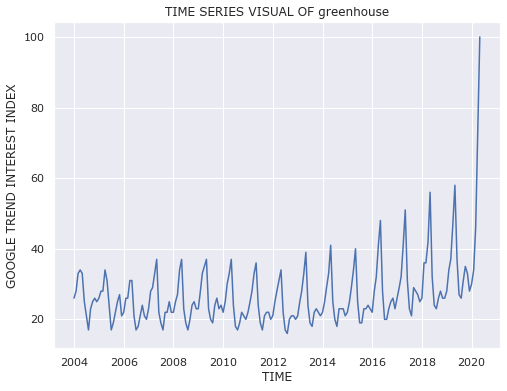

In [42]:
nice_plot(greenhouse_int, 'greenhouse')

---

In [45]:
# Using a custom function to utilize pytrends to get me the interest index
## From Google Trends Pseudo-API over a specified period of time
### Timeframe format --> 'YYYY-MM-DD YYYY-MM-DD' --> 'early recent'
# This one got '2000-01-01 current_date'
indoor_farming_int = get_int('indoor farming', '2000-01-01 2020-05-16')

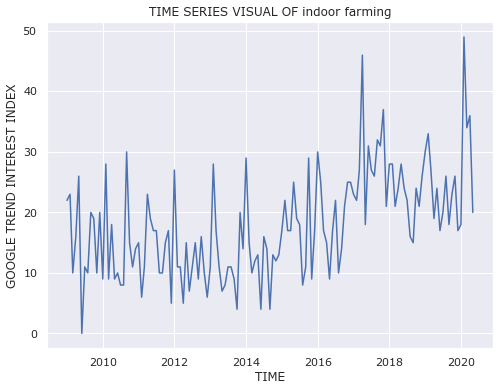

In [47]:
# Going to use my nice_plot() function to make a time series visual
nice_plot(indoor_farming_int['2009':], 'indoor farming')

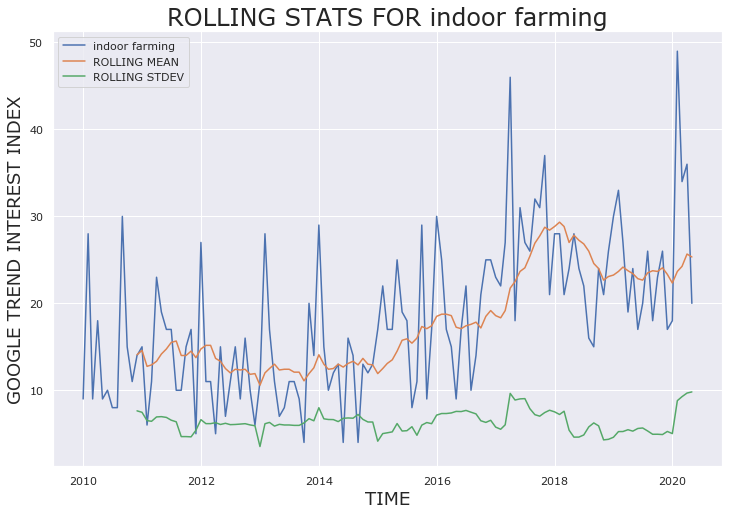

In [56]:
rolling_stats(indoor_farming_int['2010':],'indoor farming',12)

In [57]:
gen_dftest(indoor_farming_int['2010':], 'indoor farming')

Test Stat                -0.908547
P-Value                   0.785145
# Lags                    8.000000
# Observations          116.000000
Critical Value (1%)      -3.488022
Critical Value (5%)      -2.886797
Critical Value (10%)     -2.580241
dtype: float64

Time series is not stationary

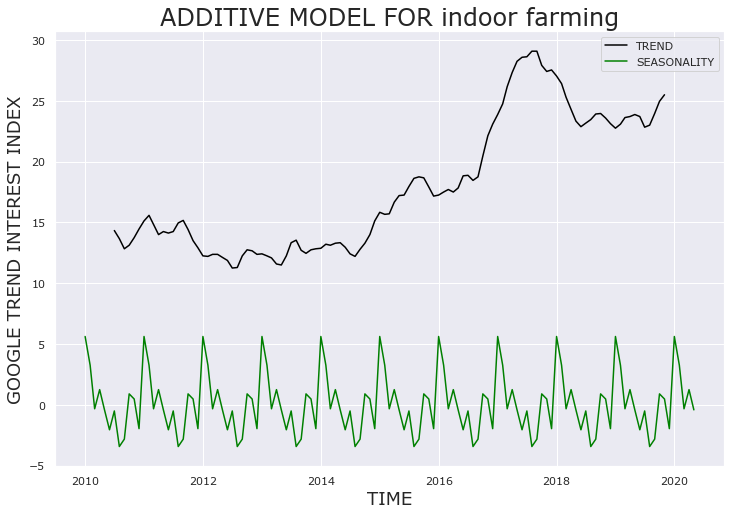

In [89]:
szn_decomp(indoor_farming_int['2010':], 'indoor farming', model=['additive'],
           graphs=['trend', 'szn'])

----

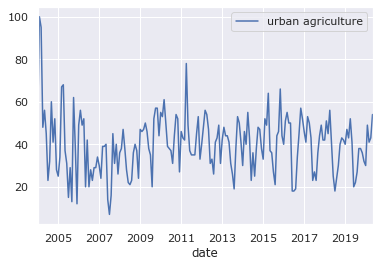

In [49]:
urban_ag_int = get_int('urban agriculture', '2000-01-01 2020-05-16')
urban_ag_int.plot()

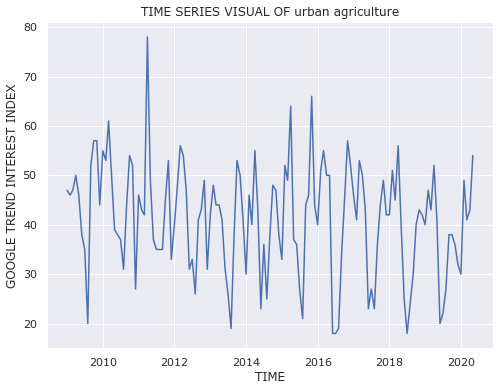

In [51]:
nice_plot(urban_ag_int['2009':], 'urban agriculture')

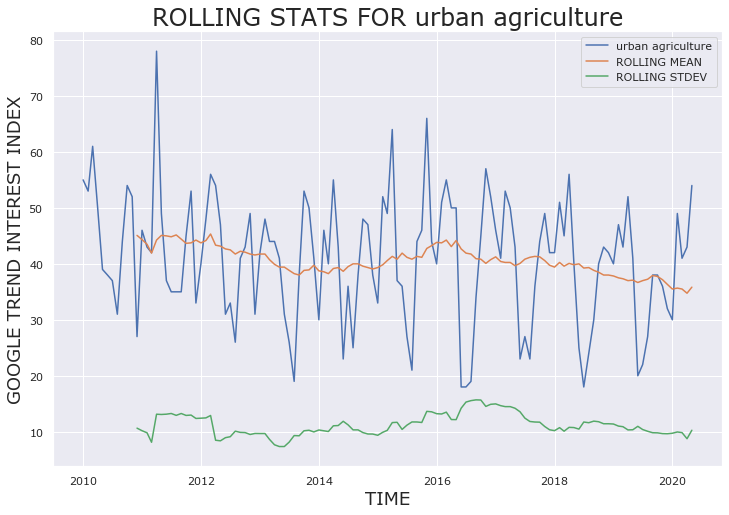

In [59]:
rolling_stats(urban_ag_int['2010':],'urban agriculture',12)

In [60]:
gen_dftest(urban_ag_int['2010':],'urban agriculture')

Test Stat                -1.191191
P-Value                   0.677373
# Lags                   12.000000
# Observations          112.000000
Critical Value (1%)      -3.490131
Critical Value (5%)      -2.887712
Critical Value (10%)     -2.580730
dtype: float64

This time series is also not stationary

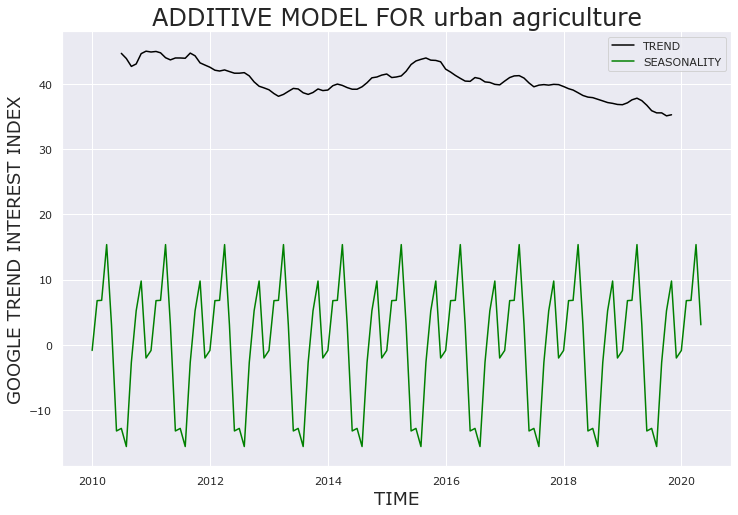

In [90]:
szn_decomp(urban_ag_int['2010':], 'urban agriculture', model=['additive'],
           graphs=['trend', 'szn'])

---

What I am thinking is if I get the data from all of the related terms to urban farming and average out the values of the data frames, I could get a better view of how the concept of something like urban farming, indoor farming, etc has become a topic of discussion over the past decade.

---

## Modeling using `auto_arima` 

In [93]:
indoor_farming_int['2010':'2015']

,indoor farming
date,
2010-01-01,9
2010-02-01,28
2010-03-01,9
2010-04-01,18
2010-05-01,9
...,...
2015-08-01,8
2015-09-01,11
2015-10-01,29


Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=True]; AIC=579.186, BIC=583.740, Time=0.329 seconds
Fit ARIMA(1,1,0)x(1,1,0,52) [intercept=True]; AIC=565.710, BIC=574.816, Time=3.107 seconds
Fit ARIMA(0,1,1)x(0,1,1,52) [intercept=True]; AIC=546.237, BIC=555.344, Time=5.885 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=False]; AIC=577.202, BIC=579.479, Time=0.458 seconds
Fit ARIMA(1,1,0)x(0,1,0,52) [intercept=True]; AIC=568.980, BIC=575.810, Time=0.823 seconds
Fit ARIMA(1,1,0)x(2,1,0,52) [intercept=True]; AIC=567.710, BIC=579.093, Time=13.218 seconds
Fit ARIMA(1,1,0)x(1,1,1,52) [intercept=True]; AIC=567.710, BIC=579.093, Time=7.111 seconds
Fit ARIMA(1,1,0)x(0,1,1,52) [intercept=True]; AIC=565.709, BIC=574.816, Time=7.142 seconds
Near non-invertible roots for order (1, 1, 0)(0, 1, 1, 52); setting 

ValueError: Either both or neither of `x` and `y` must be specified (but try passing to `data`, which is more flexible).

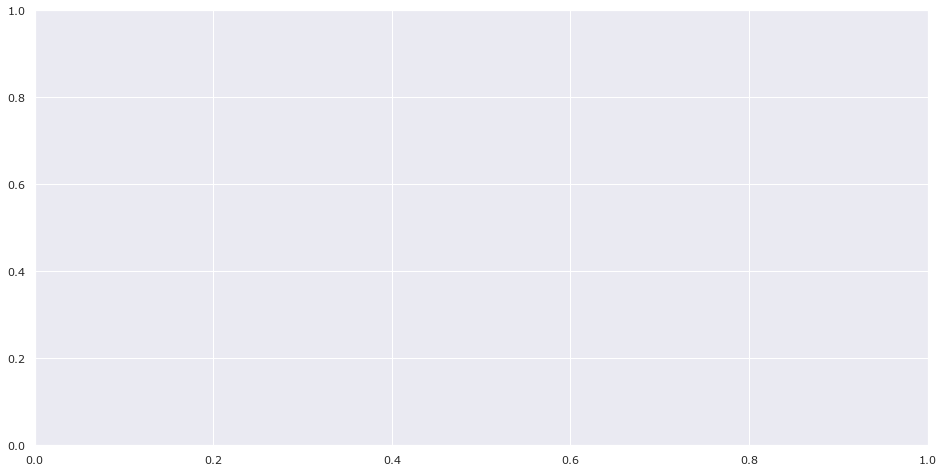

In [116]:
model = auto_arima(indoor_farming_int['2010':], start_p=0,d=1,start_q=0,start_P=0,D=1,start_Q=0,
                   trace=True, m=52, error_action='ignore', suppress_warnings=True)
model.fit(indoor_farming_int['2010':'2015'])
forecast = model.predict(n_periods=len(indoor_farming_int['2016':]))
forecast = pd.DataFrame(forecast,index = indoor_farming_int['2016':].index,columns=['Prediction'])

#plot the predictions for validation set
fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=indoor_farming_int['2010':'2015'].index, y=indoor_farming_int['2010':'2015'],
             label='Train', color='blue')
sns.lineplot(x=indoor_farming_int['2016':].index, y=indoor_farming_int['2016':],
             label='Valid', color='orange')
sns.lineplot(x=forecast.index, y=forecast, label='Prediction', color='black')
plt.show()

In [128]:
def test_plot(data,keyword):
    fig,ax = plt.subplots(figsize=(16,8))
    sns.lineplot(x=data['2010':'2015'].index,
                 y=data['2010':'2015']['indoor farming'],
                label='TRAINING', color='green')
    sns.lineplot(x=data['2016':].index,
                 y=data['2016':]['indoor farming'],
                 label='VALIDATION', color='orange')
    sns.lineplot(x=forecast.index, y=forecast['Prediction'], label='PREDICTIONS', color='black')
    plt.legend(['TRAINING DATA', 'PREDICTIONS', 'ACTUAL'], loc='best')
    plt.xlabel('TIME',size=18)
    plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
    plt.title(f'BEST SARIMA MODEL FOR %s'%keyword, size=24)
    plt.show()

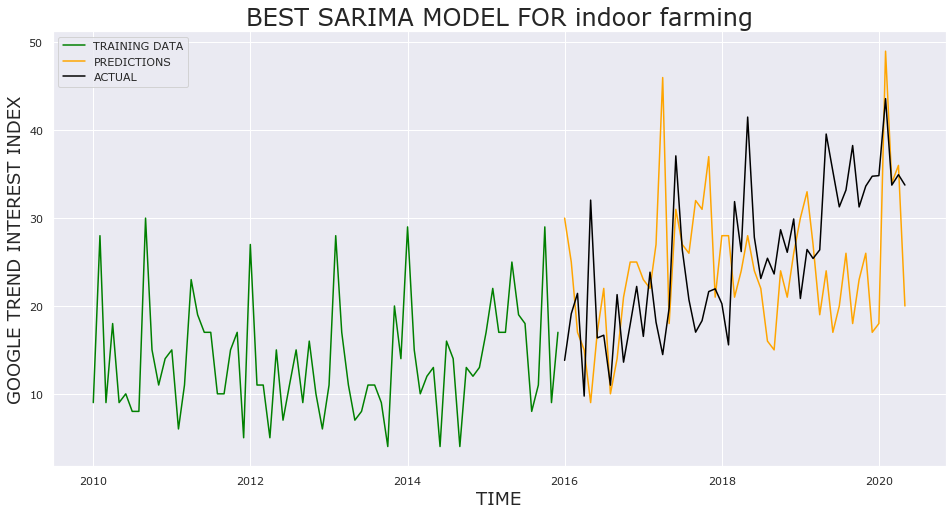

In [129]:
auto_arima

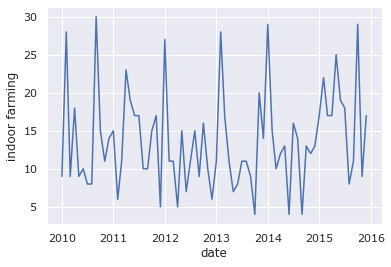

In [124]:
sns.lineplot(x=indoor_farming_int['2010':'2015'].index, y=indoor_farming_int['2010':'2015']['indoor farming'])

Really happy to see the `auto_arima` working so well, and that I am able to incorporate the seasonal component into the modeling. Will definitely be looking further into this over the weekend.  
  
Would really like now to shift gears and look into sentiment analysis with `VADER` on the tweets that I have scraped. This can be used as an exogenous variable for my time series.

Another good step to take is to get all of these fitting parameters into a data frame so the graph is easily reproducible... or just reformat how the graph comes out. That might be the better option. Create a function to run auto_arima and output a nice looking graph with titles, etc...

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=True]; AIC=579.186, BIC=583.740, Time=0.330 seconds
Fit ARIMA(1,1,0)x(1,1,0,52) [intercept=True]; AIC=565.710, BIC=574.816, Time=2.766 seconds
Fit ARIMA(0,1,1)x(0,1,1,52) [intercept=True]; AIC=546.237, BIC=555.344, Time=5.654 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=False]; AIC=577.202, BIC=579.479, Time=0.442 seconds
Fit ARIMA(1,1,0)x(0,1,0,52) [intercept=True]; AIC=568.980, BIC=575.810, Time=0.797 seconds
Fit ARIMA(1,1,0)x(2,1,0,52) [intercept=True]; AIC=567.710, BIC=579.093, Time=12.598 seconds
Fit ARIMA(1,1,0)x(1,1,1,52) [intercept=True]; AIC=567.710, BIC=579.093, Time=6.867 seconds
Fit ARIMA(1,1,0)x(0,1,1,52) [intercept=True]; AIC=565.709, BIC=574.816, Time=6.703 seconds
Near non-invertible roots for order (1, 1, 0)(0, 1, 1, 52); setting 

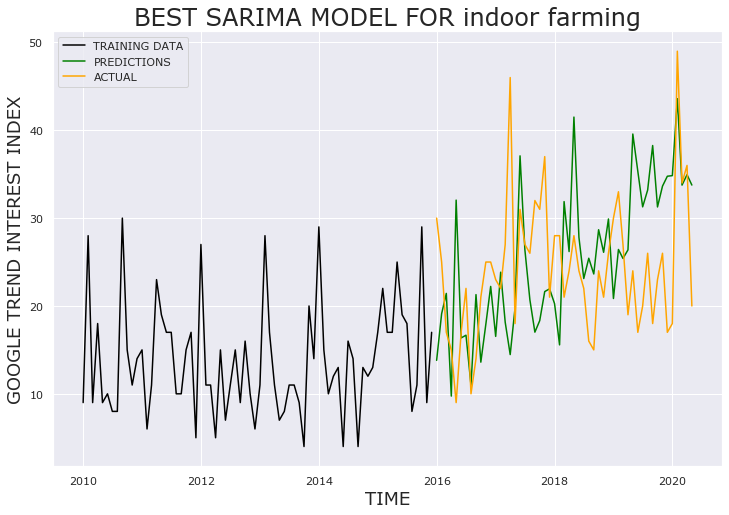

In [138]:
sarima_gs(indoor_farming_int['2010':],indoor_farming_int['2010':'2015'], indoor_farming_int['2016':],
           'indoor farming')